In [2]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
# R-like interface, alternatively you can import statsmodels as import statsmodels.api as sm
import statsmodels.formula.api as smf 
import statsmodels.api as sm
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

#### Code 6.1

In [2]:
data = {'species' : ['afarensis', 'africanus', 'habilis', 'boisei', 'rudolfensis', 'ergaster', 'sapiens'],
'brain' : [438, 452, 612, 521, 752, 871, 1350],
'mass' : [37., 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]}
d = pd.DataFrame(data)
d

,brain,mass,species
0,438,37.0,afarensis
1,452,35.5,africanus
2,612,34.5,habilis
3,521,41.5,boisei
4,752,55.5,rudolfensis
5,871,61.0,ergaster
6,1350,53.5,sapiens


#### Code 6.2

In [3]:
m_6_1 = smf.ols('brain ~ mass', data=d).fit()

#### Code 6.3

In [4]:
1 - m_6_1.resid.var()/d.brain.var()

# m_6_1.summary() check the value for R-squared

0.490158047949084

#### Code 6.4

In [5]:
m_6_2 = smf.ols('brain ~ mass + I(mass**2)', data=d).fit()

#### Code 6.5

In [6]:
m_6_3 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3)', data=d).fit()
m_6_4 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4)', data=d).fit()
m_6_5 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)', data=d).fit()
m_6_6 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5) + I(mass**6)', data=d).fit()

#### Code 6.6

In [7]:
m_6_7 = smf.ols('brain ~ 1', data=d).fit()

#### Code 6.7

In [8]:
d_new = d.drop(d.index[-1])

#### Code 6.8

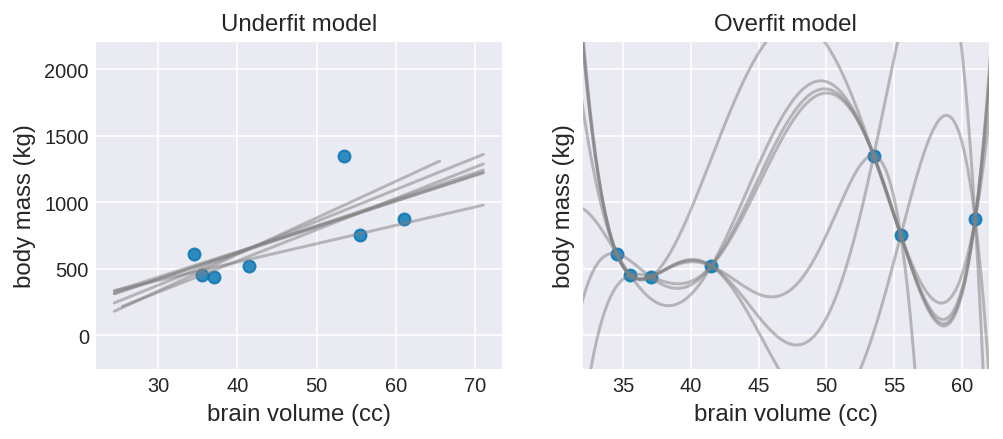

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,3))
ax1.scatter(d.mass, d.brain, alpha=0.8)
ax2.scatter(d.mass, d.brain, alpha=0.8)
for i in range(len(d)):
    d_new = d.drop(d.index[-i])
    m0 = smf.ols('brain ~ mass', d_new).fit()
    # need to calculate regression line
    # need to add intercept term explicitly
    x = sm.add_constant(d_new.mass)  # add constant to new data frame with mass
    x_pred = pd.DataFrame({'mass': np.linspace(x.mass.min() - 10, x.mass.max() + 10, 50)})  # create linspace dataframe
    x_pred2 = sm.add_constant(x_pred)  # add constant to newly created linspace dataframe
    y_pred = m0.predict(x_pred2)  # calculate predicted values
    ax1.plot(x_pred, y_pred, 'gray', alpha=.5)
    ax1.set_ylabel('body mass (kg)', fontsize=12);
    ax1.set_xlabel('brain volume (cc)', fontsize=12)
    ax1.set_title('Underfit model')
    
    # fifth order model
    m1 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)', data=d_new).fit()
    x = sm.add_constant(d_new.mass)  # add constant to new data frame with mass
    x_pred = pd.DataFrame({'mass': np.linspace(x.mass.min()-10, x.mass.max()+10, 200)})  # create linspace dataframe
    x_pred2 = sm.add_constant(x_pred)  # add constant to newly created linspace dataframe
    y_pred = m1.predict(x_pred2)  # calculate predicted values from fitted model
    ax2.plot(x_pred, y_pred, 'gray', alpha=.5)
    ax2.set_xlim(32,62)
    ax2.set_ylim(-250, 2200)
    ax2.set_ylabel('body mass (kg)', fontsize=12);
    ax2.set_xlabel('brain volume (cc)', fontsize=12)
    ax2.set_title('Overfit model')
plt.show()

#### Code 6.9

In [10]:
p = (0.3, 0.7)
-sum(p * np.log(p))

0.6108643020548935

#### Code 6.10

In [11]:
# fit model
m_6_1 = smf.ols('brain ~ mass', data=d).fit()

#compute de deviance by cheating
-2 * m_6_1.llf

94.92498968588757

#### Code 6.11

In [12]:
# standarize the mass before fitting
d['mass_s'] = d['mass'] - np.mean(d['mass'] / np.std(d['mass']))

with pm.Model() as m_6_8 :
    a = pm.Normal('a', mu=np.mean(d['brain']), sd=10)
    b = pm.Normal('b', mu=0, sd=10)
    sigma = pm.Uniform('sigma', 0, np.std(d['brain']) * 10)
    mu = pm.Deterministic('mu', a + b * d['mass_s'])
    brain = pm.Normal('brain', mu = mu, sd = sigma, observed = d['brain'])
    m_6_8 = pm.sample(1000, tune=1000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, b, a]
100%|██████████| 2000/2000 [00:02<00:00, 929.32it/s]


In [13]:
theta = pm.summary(m_6_8)['mean'][:3]

In [14]:
#compute deviance
dev = - 2 * sum(stats.norm.logpdf(d['brain'], loc = theta[0] + theta[1] * d['mass_s']  , scale = theta[2]))
dev 

100.61104197859127

#### Code 6.12 - 14

The overthinking section corresponding to cells 6.12-14 is not ported because it requires an ad-hoc rethinking package function. Feel free to contribute code to this section.  

#### Code 6.15

In [15]:
data = pd.read_csv('Data/cars.csv', sep=',')

In [16]:
with pm.Model() as m_6_15 :
    a = pm.Normal('a', mu=0, sd=100)
    b = pm.Normal('b', mu=0, sd=10)
    sigma = pm.Uniform('sigma', 0, 30)
    mu = pm.Deterministic('mu', a + b * data['speed'])
    dist = pm.Normal('dist', mu=mu, sd=sigma, observed = data['dist'])
    m_6_15 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, b, a]
100%|██████████| 2000/2000 [00:02<00:00, 706.65it/s]


#### Code 6.16

In [17]:
n_samples = 1000
n_cases = data.shape[0]
ll = np.zeros((n_cases, n_samples))

In [18]:
for s in range(0, n_samples):
    mu = m_6_15['a'][s] + m_6_15['b'][s] * data['speed']
    p_ = stats.norm.logpdf(data['dist'], loc=mu, scale=m_6_15['sigma'][s])
    ll[:,s] = p_

#### Code 6.17

In [19]:
from scipy.misc import logsumexp
n_cases = data.shape[0]
lppd = np.zeros((n_cases))
for a in range(1, n_cases):
    lppd[a,] = logsumexp(ll[a,]) - np.log(n_samples)

/home/osvaldo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  """


#### Code 6.18

In [20]:
pWAIC = np.zeros((n_cases))
for i in range(1, n_cases):
    pWAIC[i,] = np.var(ll[i,])

#### Code 6.19

In [21]:
- 2 * (sum(lppd) - sum(pWAIC))

411.9614760557469

#### Code 6.20

In [22]:
waic_vec = - 2 * (lppd - pWAIC)
np.sqrt(n_cases * np.var(waic_vec))

15.064152723297704

#### Code 6.21

In [23]:
d = pd.read_csv('Data/milk.csv', sep=';')
d['neocortex'] = d['neocortex.perc'] / 100
d.dropna(inplace=True)
d.shape

(17, 9)

#### Code 6.22

In [24]:
a_start = d['kcal.per.g'].mean()
sigma_start = d['kcal.per.g'].std()

In [25]:
import theano

mass_shared = theano.shared(np.log(d['mass'].values))
neocortex_shared = theano.shared(d['neocortex'].values)

with pm.Model() as m6_11:
    alpha = pm.Normal('alpha', mu=0, sd=10, testval=a_start)
    mu = alpha + 0 * neocortex_shared
    sigma = pm.HalfCauchy('sigma',beta=10, testval=sigma_start)
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=d['kcal.per.g'])
    trace_m6_11 = pm.sample(1000, tune=1000)    

with pm.Model() as m6_12:
    alpha = pm.Normal('alpha', mu=0, sd=10, testval=a_start)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.HalfCauchy('sigma',beta=10, testval=sigma_start)
    mu = alpha + beta * neocortex_shared
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=d['kcal.per.g'])
    trace_m6_12 = pm.sample(1000, tune=1000)
    
with pm.Model() as m6_13:
    alpha = pm.Normal('alpha', mu=0, sd=10, testval=a_start)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.HalfCauchy('sigma', beta=10, testval=sigma_start)
    mu = alpha + beta * mass_shared
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=d['kcal.per.g'])
    trace_m6_13 = pm.sample(1000, tune=1000)
    
with pm.Model() as m6_14:
    alpha = pm.Normal('alpha', mu=0, sd=10, testval=a_start)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfCauchy('sigma', beta=10, testval=sigma_start)
    mu = alpha + beta[0] * mass_shared + beta[1] * neocortex_shared
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=d['kcal.per.g'])
    trace_m6_14 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, alpha]
100%|██████████| 2000/2000 [00:01<00:00, 1640.22it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, beta, alpha]
100%|██████████| 2000/2000 [00:09<00:00, 211.15it/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7164696602187042, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, beta, alpha]
100%|██████████| 2000/2000 [00:01<00:00, 1131.22it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multi

#### Code 6.23

In [26]:
pm.waic(trace_m6_14, m6_14)

/home/osvaldo/proyectos/00_PyMC3/pymc3/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=-16.829957464146045, WAIC_se=5.153566115574905, p_WAIC=3.145792948267894, var_warn=1)

#### Code 6.24

In [27]:

compare_df = pm.compare({m6_11 : trace_m6_11,
                         m6_12 : trace_m6_12,
                         m6_13 : trace_m6_13,
                         m6_14 : trace_m6_14}, method='pseudo-BMA')

compare_df.loc[:,'model'] = pd.Series(['m6.11', 'm6.12', 'm6.13', 'm6.14'])
compare_df = compare_df.set_index('model')
compare_df

/home/osvaldo/proyectos/00_PyMC3/pymc3/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m6.14,-16.83,3.15,0,0.96,5.15,0,1
m6.13,-8.87,2.03,7.96,0.02,4.06,3.55,1
m6.11,-8.69,1.35,8.14,0.02,3.64,4.9,0
m6.12,-7.35,1.87,9.48,0.01,3.19,5.02,0


#### Code 6.25

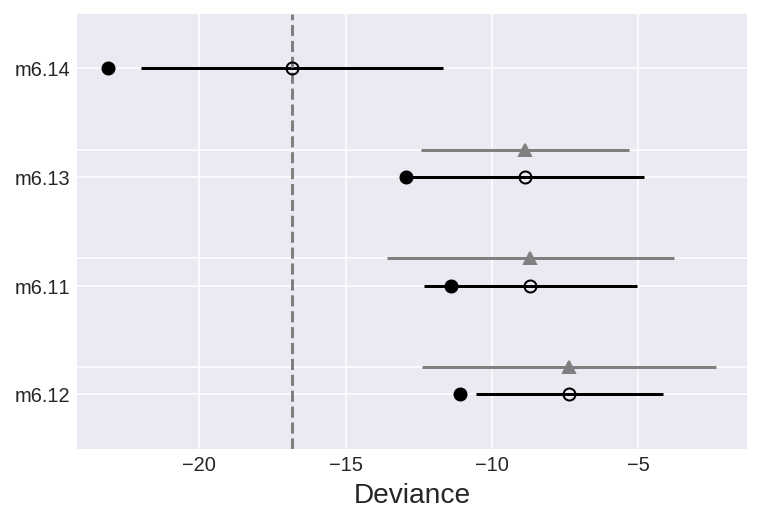

In [28]:
pm.compareplot(compare_df);

#### Code 6.26

In [29]:
diff = np.random.normal(loc=6.7, scale=7.26, size=100000)
sum(diff[diff<0]) / 100000

-0.7043786989415347

#### Code 6.27

Compare function already checks number of observations to be equal.

In [30]:
coeftab = pd.DataFrame({'m6_11': pm.summary(trace_m6_11)['mean'],
                        'm6_12': pm.summary(trace_m6_12)['mean'],
                        'm6_13': pm.summary(trace_m6_13)['mean'],
                        'm6_14': pm.summary(trace_m6_14)['mean']})
coeftab

,m6_11,m6_12,m6_13,m6_14
alpha,0.655726,0.354943,0.700296,-1.061794
beta,NaN,0.445755,-0.030359,NaN
beta__0,NaN,NaN,NaN,-0.096054
beta__1,NaN,NaN,NaN,2.758729
sigma,0.188297,0.192283,0.183641,0.138765


#### Code 6.28

In [31]:
traces = [trace_m6_11, trace_m6_12, trace_m6_13, trace_m6_14]   
models = [m6_11, m6_12, m6_13, m6_14]

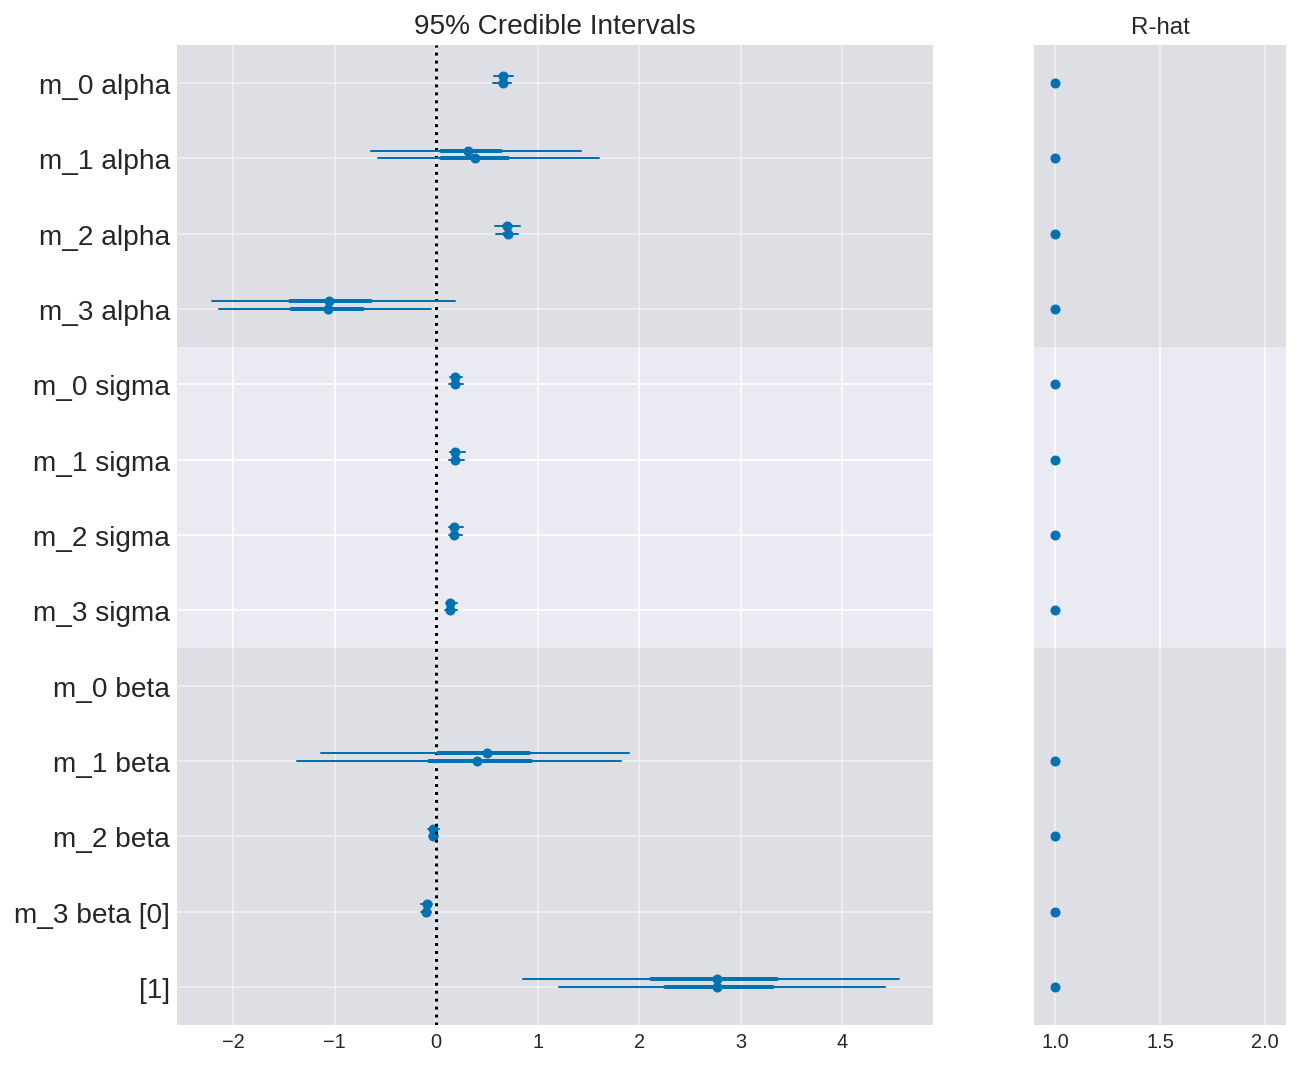

In [32]:
plt.figure(figsize=(10, 8))
pm.forestplot(traces, plot_kwargs={'fontsize':14});

#### Code 6.29

In [33]:
kcal_per_g = np.repeat(0, 30) # empty outcome
neocortex = np.linspace(0.5, 0.8, 30) # sequence of neocortex
mass = np.repeat(4.5, 30)     # average mass

In [34]:
mass_shared.set_value(np.log(mass))
neocortex_shared.set_value(neocortex)
post_pred = pm.sample_ppc(trace_m6_14, samples=10000, model=m6_14)

100%|██████████| 10000/10000 [00:03<00:00, 3315.34it/s]


#### Code 6.30

In [35]:
milk_ensemble = pm.sample_ppc_w(traces, 10000, 
                                models, weights=compare_df.weight.sort_index(ascending=True))

100%|██████████| 10000/10000 [00:03<00:00, 3004.79it/s]


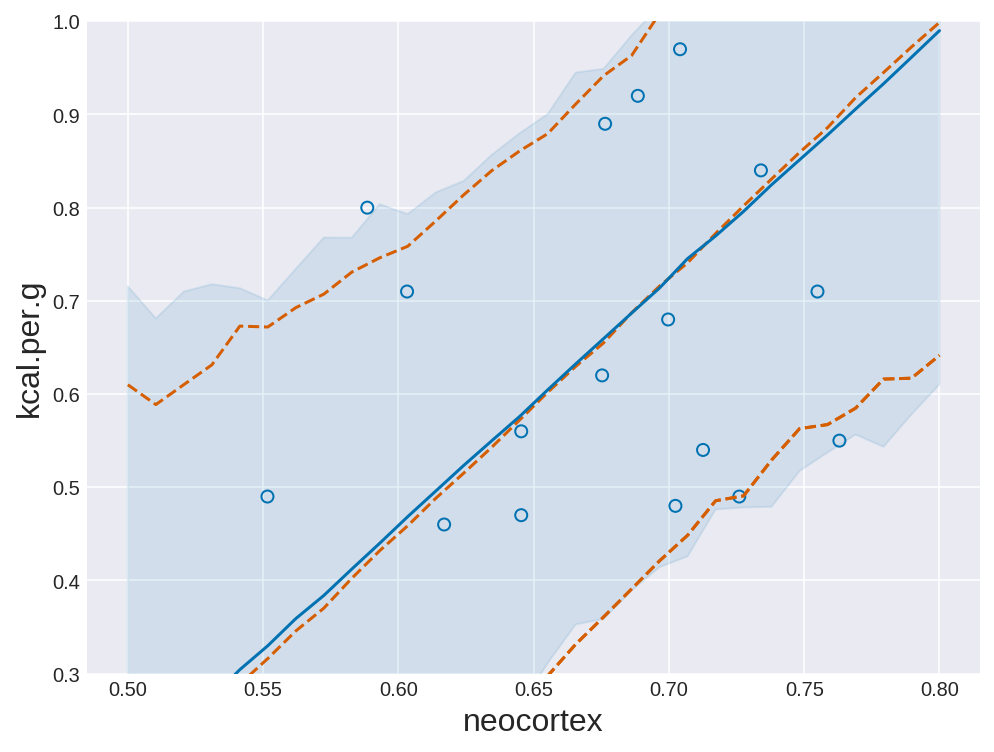

In [36]:
plt.figure(figsize=(8, 6))

plt.plot(neocortex, post_pred['kcal'].mean(0), ls='--', color='C2')
hpd_post_pred = pm.hpd(post_pred['kcal'])
plt.plot(neocortex,hpd_post_pred[:,0], ls='--', color='C2')
plt.plot(neocortex,hpd_post_pred[:,], ls='--', color='C2')

plt.plot(neocortex, milk_ensemble['kcal'].mean(0), color='C0')
hpd_av = pm.hpd(milk_ensemble['kcal'])
plt.fill_between(neocortex, hpd_av[:,0], hpd_av[:,1], alpha=0.1, color='C0')

plt.scatter(d['neocortex'], d['kcal.per.g'], facecolor='None', edgecolors='C0')

plt.ylim(0.3, 1)
plt.xlabel('neocortex', fontsize=16)
plt.ylabel('kcal.per.g', fontsize=16);

In [37]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__))

This notebook was createad on a computer x86_64 running debian stretch/sid and using:
Python 3.6.3
IPython 6.3.1
PyMC3 3.4.1
NumPy 1.14.2
Pandas 0.22.0
SciPy 1.0.1
Matplotlib 2.2.2

